In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt
import pandas as pd
from extquadcontrol import dp_finite, dp_infinite, ExtendedQuadratic, extended_quadratic_to_cvx
from scipy.linalg import block_diag
from system import FiniteHorizonSystem,InfiniteHorizonSystem
from policy import AffinePolicy,Policy,TimeInvariantAffinePolicy
import cvxpy as cvx

from iexfinance import get_historical_data
from datetime import datetime
import pandas as pd

In [3]:
import quandl;
quandl.ApiConfig.api_key = "INSERT API KEY HERE"
tickers = ['FXI','GDX','IWM','QQQ','SPY','XLF','XOP']
n = len(tickers)
P = []
for t in tickers:
    df = get_historical_data(t, output_format='pandas')
    P.append(np.array(df.open)[:,None])
prices = np.concatenate(P,axis=1) 

In [4]:
vix = np.array(quandl.get('CHRIS/CBOE_VX5',start_date='2011-01-01').Open)[-prices.shape[0]:]

In [5]:
vix = vix[:-1]
prices = prices[1:]

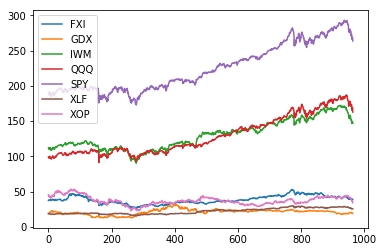

In [6]:
i = 0
for p in prices.T:
    plt.plot(p,label=tickers[i])
    i += 1
plt.legend()

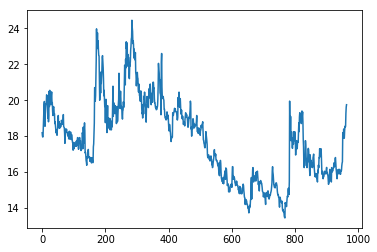

In [7]:
plt.plot(vix)

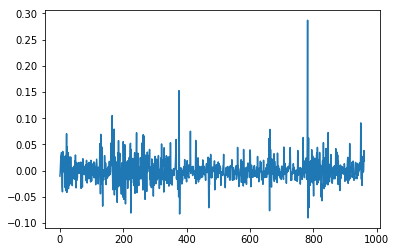

In [8]:
dvix = np.diff(vix)/vix[:-1]
dvix = dvix[:-1]
plt.plot(dvix)

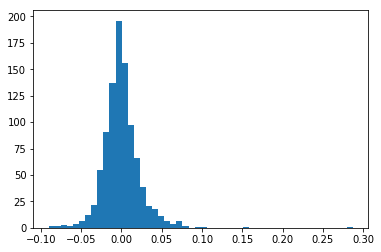

In [9]:
plt.hist(dvix, bins=50);

In [10]:
ranges = np.r_[
    -np.logspace(-2.5,np.log10(-np.min(dvix)+1e-4),3)[::-1],
    np.logspace(-2.5,np.log10(np.max(dvix)+1e-4),3)
]
np.set_printoptions(precision=3)
ranges

array([-0.09 , -0.017, -0.003,  0.003,  0.03 ,  0.287])

In [11]:
cut = pd.cut(dvix,ranges,labels=np.arange(len(ranges)-1))
cut.value_counts()

0    158
1    261
2    167
3    304
4     72
dtype: int64

In [12]:
K = len(cut.value_counts())
Pi = 0*np.ones((K,K))
for i in range(len(cut)-1):
    Pi[cut[i+1],cut[i]] += 1

In [13]:
Pi/=np.sum(Pi,axis=0)

array([[0.158, 0.123, 0.144, 0.188, 0.278],
       [0.241, 0.291, 0.293, 0.274, 0.194],
       [0.114, 0.215, 0.204, 0.158, 0.153],
       [0.354, 0.318, 0.305, 0.32 , 0.236],
       [0.133, 0.054, 0.054, 0.059, 0.139]])

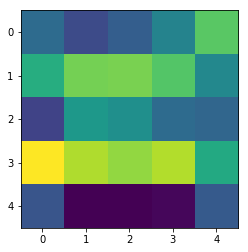

In [14]:
plt.imshow(Pi)
Pi
# Pi = np.eye(K)

In [15]:
returnslog = np.log(1+np.diff(prices,axis=0)/prices[:-1])
returnslog = returnslog[1:]
mus = []
sigmas = []
means = []
covs = []
for i in range(K):
    mu = np.mean(returnslog[cut==i],axis=0)
    sigma = np.cov(returnslog[cut==i].T) + 1e-10*np.eye(n)
    mus.append(mu)
    sigmas.append(sigma)
    
    mean = np.exp(mu + .5*np.diag(sigma))
    covariance = np.diag(mean)@(np.exp(sigma)-np.ones((n,n)))@np.diag(mean)
    means.append(mean)
    covs.append(covariance)

In [16]:
means

[array([1.   , 1.001, 1.001, 1.002, 1.001, 1.001, 1.002]),
 array([1.   , 1.   , 0.999, 0.999, 1.   , 1.   , 1.   ]),
 array([1.001, 0.998, 1.   , 1.   , 1.   , 1.   , 1.   ]),
 array([1.   , 1.001, 1.001, 1.001, 1.001, 1.001, 0.998]),
 array([0.999, 1.001, 1.   , 1.   , 1.   , 1.   , 1.003])]

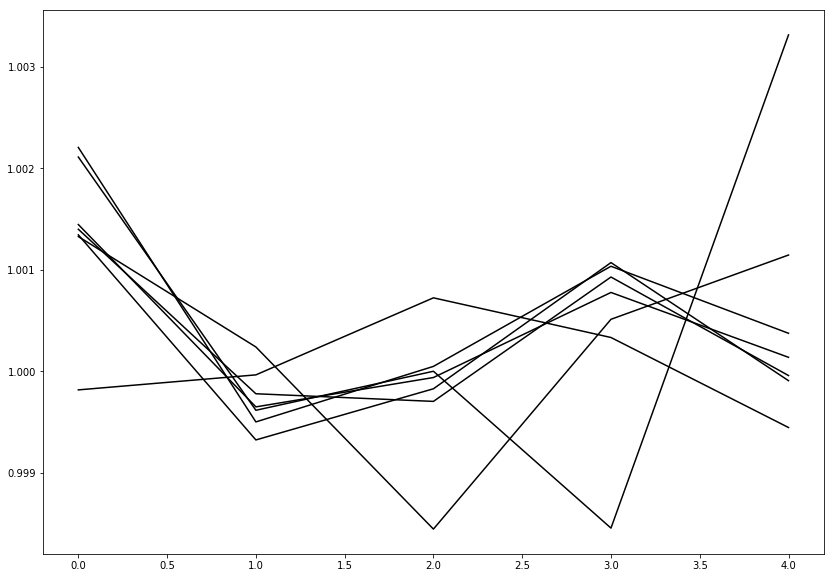

In [17]:
np.set_printoptions(precision=5,suppress=True)
plt.figure(figsize=(14,10))
for i in range(n):
    plt.plot([m[i] for m in means], c='black')

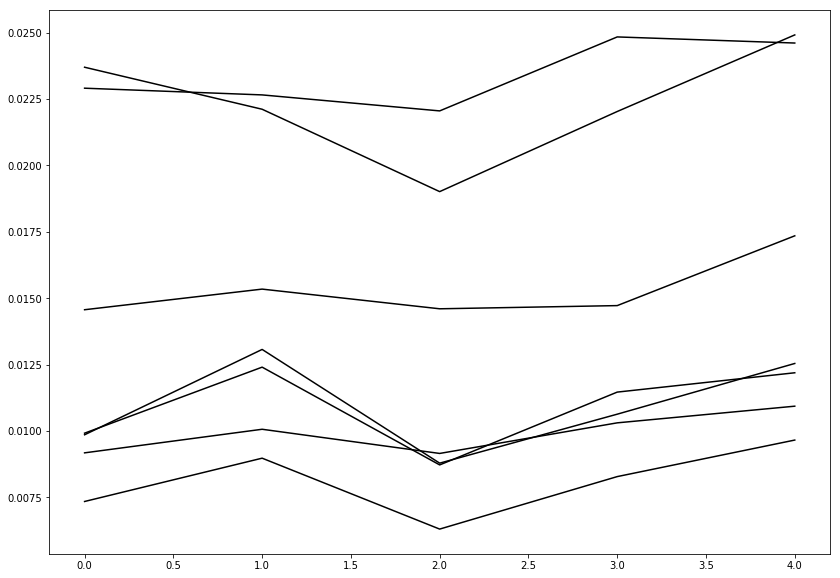

In [18]:
plt.figure(figsize=(14,10))
for i in range(n):
    plt.plot([np.sqrt(c[i,i]) for c in covs], c='black')

In [19]:
means[4]

array([0.99944, 1.00115, 0.99991, 1.00037, 1.00014, 0.99996, 1.00332])

In [20]:
covs[4]

array([[ 0.0003 , -0.00003,  0.00011,  0.00015,  0.00012,  0.00015,
         0.00021],
       [-0.00003,  0.00061, -0.00002, -0.00002, -0.00002, -0.00007,
         0.00005],
       [ 0.00011, -0.00002,  0.00012,  0.0001 ,  0.00009,  0.00011,
         0.00016],
       [ 0.00015, -0.00002,  0.0001 ,  0.00016,  0.00011,  0.00012,
         0.00014],
       [ 0.00012, -0.00002,  0.00009,  0.00011,  0.00009,  0.00011,
         0.00014],
       [ 0.00015, -0.00007,  0.00011,  0.00012,  0.00011,  0.00015,
         0.00017],
       [ 0.00021,  0.00005,  0.00016,  0.00014,  0.00014,  0.00017,
         0.00062]])

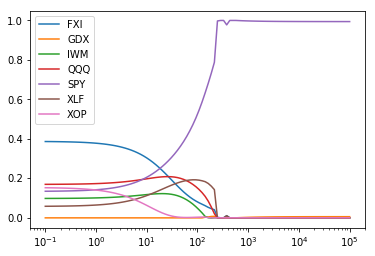

In [21]:
w = cvx.Variable(n)
ws = []
for gamma in np.logspace(-1,5,100):
    objective = -means[2]*w + gamma/2*cvx.quad_form(w,covs[2])
    constraints = [np.ones(n)*w == 1, w >=0]

    problem = cvx.Problem(cvx.Minimize(objective),constraints)
    result = problem.solve(solver='OSQP')
    ws.append(np.array(w.value)[:,None])
ws = np.concatenate(ws,axis=1)
for i in range(n):
    plt.semilogx(np.logspace(-1,5,100),ws[i], label=tickers[i])
plt.legend()

In [22]:
b = [prices[-1]*1e-7 for _ in range(K)]
gamma = 1e-1
T = 30
N = 30

def sample(t,N):
    As = np.zeros((N,K,n,n))
    Bs = np.zeros((N,K,n,n))
    cs = np.zeros((N,K,n))
    for s in range(K):
        mu,sigma=mus[s],sigmas[s]
        r = np.exp(np.random.multivariate_normal(mu,sigma,size=N))
        for i in range(n):
            As[:,s,i,i] = r[:,i]
            Bs[:,s,i,i] = r[:,i]
    gs = []
    for s in range(K):
        mean,cov = means[s],covs[s]
        g = ExtendedQuadratic(np.c_[np.r_[gamma*cov,gamma*cov],np.r_[gamma*cov,gamma*cov+np.diag(b[s])]],-np.r_[mean,mean],0,np.c_[np.zeros((1,n)),np.ones((1,n))],np.zeros(1))
        gs.append(g)
    return As,Bs,cs,[gs for _ in range(N)],Pi
sample_infinite = lambda N: sample(0,N)
g_T = [ExtendedQuadratic(np.zeros((n,n)),np.zeros(n),0) for s in range(K)]

In [23]:
Vs, Qs, policies = dp_finite(sample,g_T,T,N)
V = Vs[0]
Q = Qs[0]
policy = policies[0]

In [24]:
Kpolicy,kpolicy = policy[0]
# Kpolicy

In [25]:
xstar = -np.linalg.lstsq(Kpolicy,kpolicy,rcond=None)[0]
np.allclose(-Kpolicy@xstar,kpolicy)

True

In [26]:
np.set_printoptions(precision=3,suppress=False)
for i in range(n):
    print (tickers[i], (xstar/np.sum(xstar))[i])

FXI -2.918854996432674
GDX 0.03209016009921318
IWM -3.934407409272246
QQQ 3.2109382612173043
SPY 1.4914007172012218
XLF 1.9876683137411342
XOP 1.1311649534460466


In [27]:
np.linalg.eigvals(Kpolicy)

array([-1.221e-15, -1.306e-01, -2.940e-01, -4.586e-01, -7.650e-01,
       -9.591e-01, -9.113e-01])

In [28]:
system = InfiniteHorizonSystem(sample_infinite,K)

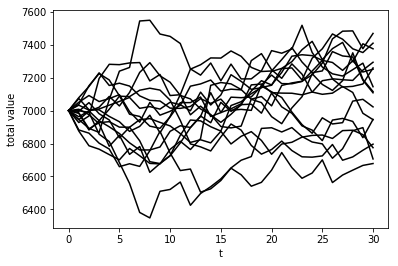

In [29]:
final_wealths = []
np.random.seed(1)
for i in range(100):
    Xs, Us, Modes, cost = system.simulate(1000*np.ones(n),3,30,TimeInvariantAffinePolicy(policy)) 
    if i <= 15:
        plt.plot(np.sum(Xs,axis=1),color='black')
    final_wealths.append(np.sum(Xs,axis=1)[-1])
plt.ylabel('total value')
plt.xlabel('t')
plt.savefig('figs/portfolio1.pdf')

In [30]:
Xs.shape

(31, 7)

In [31]:
# Xs/np.sum(Xs,axis=1)[:,None]

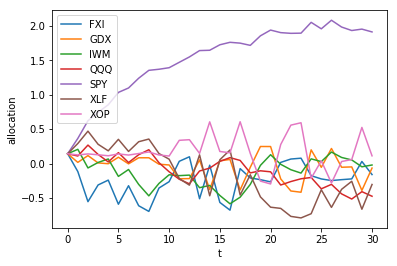

In [32]:
i = 0
for x in (Xs/Xs.sum(axis=1)[:,None]).T:
    plt.plot(x, label=tickers[i])
    i += 1
plt.legend()
plt.ylabel('allocation')
plt.xlabel('t')
plt.savefig('figs/portfolio2.pdf')

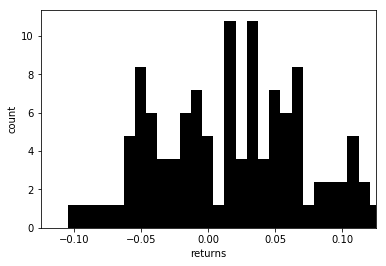

In [33]:
plt.hist(np.array(final_wealths)/(1000*n)-1.,bins=30,color='black',density=True);
plt.xlim(-.125,.125)
plt.ylabel('count')
plt.xlabel('returns')
plt.savefig('figs/portfolio3.pdf')

In [34]:
100*(np.mean(np.array(final_wealths)/(1000*n))-1)

1.7229690763680416

In [35]:
np.std(100*np.array(final_wealths)/(1000*n))

5.525863049728328

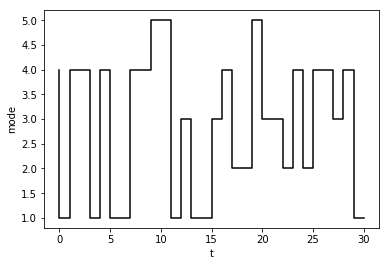

In [36]:
plt.step(np.arange(len(Modes)),np.array(Modes)+1, color='black')
plt.ylabel('mode')
plt.xlabel('t')
plt.savefig('figs/portfolio4.pdf')

In [37]:
# plt.plot(np.sum(np.abs(Us),axis=1),color='black')
# plt.ylabel('trading volume')
# plt.xlabel('t')
# plt.savefig('figs/portfolio3.pdf')

In [38]:
class LongOnlyPolicy(Policy):
    def __init__(self, Q):
        self.Q = Q

    def __call__(self, t, x, s):
        Q = self.Q[s]
        Q = Q.affine_composition(np.r_[np.zeros((n,n)),np.eye(n)],np.r_[x,np.zeros(n)])
        u = cvx.Variable(n)
        Q, constraints = extended_quadratic_to_cvx(Q, u)
        problem = cvx.Problem(cvx.Minimize(Q), constraints+[x+u>=1e-3])
        result = problem.solve(solver='OSQP')
        return np.array(u.value).flatten()

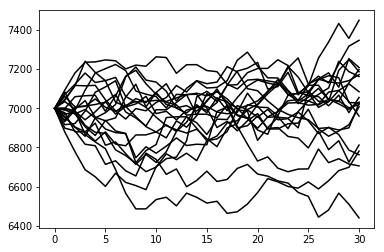

In [39]:
np.random.seed(1)
final_wealths = []
for _ in range(20):
    Xs, Us, Modes, cost = system.simulate(1000*np.ones(n),3,T,LongOnlyPolicy(Q)) 
    plt.plot(np.sum(Xs,axis=1),color='black')
    final_wealths.append(np.sum(Xs,axis=1)[-1])
plt.savefig('figs/portfolio1-longonly.pdf')

In [40]:
np.mean(np.array(final_wealths)/(1000*n))

1.0031079709078403

In [41]:
np.std(np.array(final_wealths)/(1000*n))

0.03259526587364521

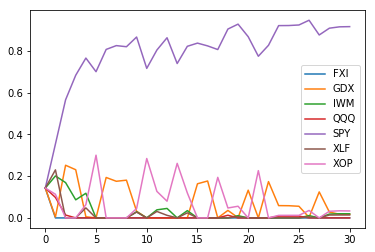

In [42]:
i = 0
for x in (Xs/Xs.sum(axis=1)[:,None]).T:
    plt.plot(x, label=tickers[i])
    i += 1
plt.legend()
plt.savefig('figs/portfolio2-longonly.pdf')

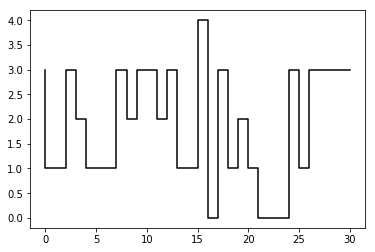

In [43]:
plt.step(np.arange(len(Modes)),Modes, color='black')
plt.savefig('figs/portfolio4-longonly.pdf')

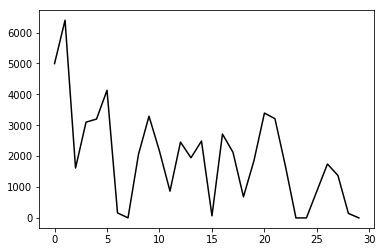

In [44]:
plt.plot(np.sum(np.abs(Us),axis=1),color='black')
plt.savefig('figs/portfolio3-longonly.pdf')